In [1]:
%matplotlib inline

## Imports

In [61]:
import numpy as np
import sys
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import socket
import pyFAI as pf
from pyFAI.gui import jupyter
from pyFAI.gui.jupyter.calib import Calibration

from tqdm import tqdm

import sys
from pathlib import Path

import ana_fun as ana

from utilities import *

print(f"PyFAI version {pf.version}")


PyFAI version 0.21.3


In [3]:
# constants
h = 4.135667516*1e-18 # kev*sec
c = 3*1e8 # m/s

# setup
sdd = 4.3 # sample-detector distance in meters
energy = 9.5 # energy of the x-rays in keV
wavelength = h*c/energy*1e10 # wavelength of the x-rays (A-1)
beamstop_radius = 1.5e-3 # meter

# epix params
epix_pixel_size = 50e-6 # meter
epix_npixel = (704, 768)
epix_center = (int(epix_npixel[0]/2), int(epix_npixel[0]/2))

# smalldata path
exp = 'xppl1001021'
p = Path('/sdf/data/lcls/ds/{}/{}'.format(exp[:3], exp))
smalldata = Path(p, 'hdf5', 'smalldata')
jungfrau_data = Path(p, 'hdf5', 'smalldata', 'jungfrau')
results = Path(p, 'results')
shared = Path(results, 'shared')
print('Smalldata path exists:', jungfrau_data.exists())

Smalldata path exists: True


### Estimations

Q estimation from distance or angle

In [15]:
def d_to_twotheta(d):
    """ calculate scattering angle """
    twotheta = np.arctan(d / sdd) # radiant
    return twotheta

def twotheta_to_q(twotheta):
    """ calculate momentum transfer q from the scattering angle """
    q = 4*np.pi / wavelength * np.sin(twotheta/2)*1e1 # in nm-1
    return q

In [16]:
twotheta_min = d_to_twotheta(beamstop_radius + 2*epix_pixel_size)
twotheta_max = d_to_twotheta(np.sqrt(epix_center[0]**2 + epix_center[1]**2) * epix_pixel_size)

qmin = twotheta_to_q(twotheta_min)
qmax = twotheta_to_q(twotheta_max)

print(f"The q range is: {qmin:.3f} - {qmax:.3f} 1/nm") 

The q range is: 0.018 - 0.278 1/nm


## Raw Data

In [477]:
run = 37
ds = psana.MPIDataSource('exp=xppl1001021:run={}'.format(run))
#ds.break_after(100) # stop iteration after 3 events (break statements do not work reliably with MPIDataSource).
detname = 'epix_alc5'
det = psana.Detector(detname) 
nimg = 1000
for nevt,evt in tqdm(enumerate(ds.events())):
    if nevt == nimg: break
    img = det.image(evt)
    if nevt == 0:
        imgs = np.zeros(np.r_[nimg, img.shape])
    imgs[nevt] = det.image(evt)

1000it [01:31, 10.90it/s]


In [478]:
np.save(f'{detname}_raw_img_run{run}', imgs.mean(axis = 0))

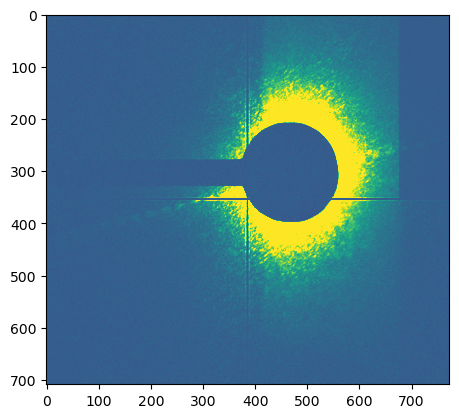

In [483]:
img = np.load(Path(results, 'jason', f'{detname}_raw_img_run{run}.npy'))
plt.imshow(img.T, vmax=1)

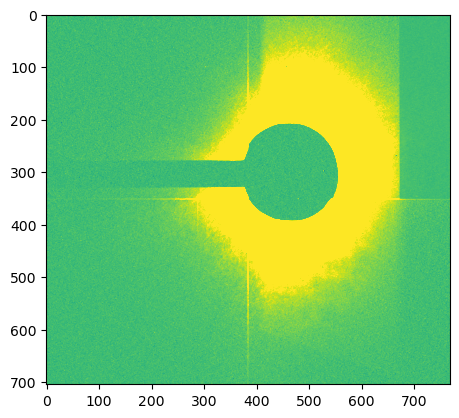

In [476]:
plt.imshow(epix5_mask, vmax=5000)

In [ ]:
custom_f = Path(results, 'haoyuan/output/jungfrau1M_run_37.h5')
with h5py.File(custom_f) as h5:
    jg_imgs = np.empty(shape=(1000, 1064, 1030)) 
    for i in range(1000):
        jg_imgs[i] = h5[f'{i}'][:]
    

In [87]:
jg_img = jg_imgs.mean(0).clip(0,1)

In [95]:
np.save('jungfrau_run37_calib', jg_img)

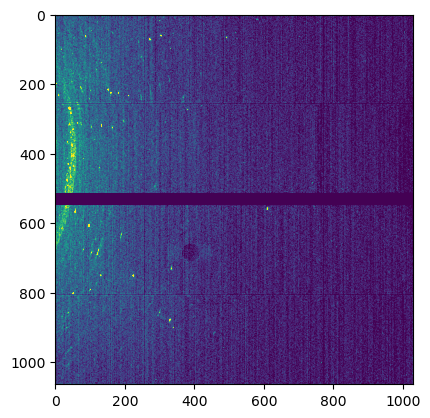

In [94]:
plt.imshow(jg_img, vmin=0.01, vmax=0.2)

## Check h5 files

In [465]:
def visit_func(name, node):
    """Return all groups and datasets name and shapes of h5 file called name
    Use it as in the following:
    with h5py.File(filename, 'a') as f: f.visititems(visit_func)
    """
    if isinstance(node, h5py.Group):
        print("group", node.name)
    elif isinstance(node, h5py.Dataset):
        print('\t', node.name, node.shape)
    else:
        print(node.name, 'is an unknown type')

In [485]:
# Run & experiment number
run = 70
# iterator over runs to check run exists
it = smalldata.glob('{}_Run{:04d}*'.format(exp, run))
try:
    f = next(it)
    print(f)
    print('\n')
except: print('No files found at this path.')

# path to run
f = Path(smalldata, f'{exp}_Run{run:04d}.h5')
with h5py.File(f) as h5:
    print(h5.visititems(visit_func))

/sdf/data/lcls/ds/xpp/xppl1001021/hdf5/smalldata/xppl1001021_Run0070.h5


group /Sums
	 /Sums/epix_alc1_calib (704, 768)
	 /Sums/epix_alc1_calib_dropped (704, 768)
	 /Sums/epix_alc1_calib_dropped_square (704, 768)
	 /Sums/epix_alc2_calib (704, 768)
	 /Sums/epix_alc2_calib_dropped (704, 768)
	 /Sums/epix_alc2_calib_dropped_square (704, 768)
	 /Sums/epix_alc3_calib (704, 768)
	 /Sums/epix_alc3_calib_dropped (704, 768)
	 /Sums/epix_alc3_calib_dropped_square (704, 768)
	 /Sums/epix_alc4_calib (704, 768)
	 /Sums/epix_alc4_calib_dropped (704, 768)
	 /Sums/epix_alc4_calib_dropped_square (704, 768)
	 /Sums/jungfrau1M_alcove_calib (2, 512, 1024)
	 /Sums/jungfrau1M_alcove_calib_dropped (2, 512, 1024)
	 /Sums/jungfrau1M_alcove_calib_dropped_square (2, 512, 1024)
group /UserDataCfg
group /UserDataCfg/EOrbits
	 /UserDataCfg/EOrbits/detname (1,)
	 /UserDataCfg/EOrbits/name (1,)
group /UserDataCfg/ai
	 /UserDataCfg/ai/detname (1,)
	 /UserDataCfg/ai/name (1,)
group /UserDataCfg/damage
	 /UserDataCfg/d

### Thresholding

In [47]:
run = 35
with h5py.File(Path(results, 'haoyuan', 'output/jungfrau1M_run_{}.h5'.format(run)), 'r') as source:
    result = np.zeros((1064, 1030))
    
    for idx in range(1000):
        data = np.array(source['{}'.format(idx)])
        result[np.logical_and(data >= 1, data <= 100)] += data[np.logical_and(data >= 1, data <= 100)]

In [52]:
np.save('jungfrau_run35_threshold.npy', result)

In [48]:
np.median(result)

18.35574734210968

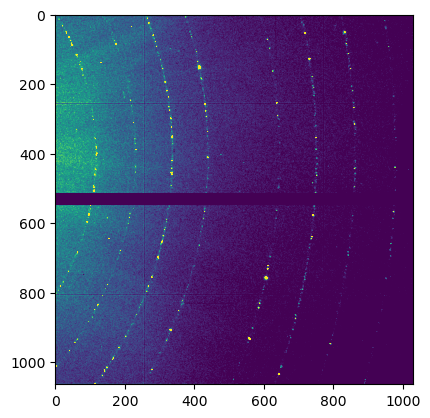

In [51]:
plt.imshow(result, vmin=10, vmax=150)

### Loading

In [487]:
epix_photons_i = []
epix_photons_j = []
epix_masks = []
with h5py.File(f) as h5:
    # epix5_mask = h5[f'/Sums/epix_alc5_calib'][:]
    # epix5_mask = h5[f'/UserDataCfg/epix_alc5/mask'][:]
    # droplet_mask = h5['UserDataCfg/epix_alc5/ragged_droplet_ragged_droplet_mask'][:] # we added a droplet mask 
    # epix5_photons_j = h5['epix_alc5/ragged_droplet_photon_j'][:]
    # epix5_photons_i = h5['epix_alc5/ragged_droplet_photon_i'][:]
    i_sample = h5['lombpm']['channels'][:,1]
    # cc = np.array(f['ai/ch03'])
    # vcc = np.array(f['ai/ch02'])
    # jg_img = h5['Sums/jungfrau1M_alcove_calib_img'][:]
    jg_dropp = h5['Sums/jungfrau1M_alcove_calib'][:]
    jg_mask = h5['/UserDataCfg/jungfrau1M_alcove/mask'][:]
    # jg_pyfai_az = h5['/jungfrau1M_alcove/pyfai_az'][:]
    # jg_pyfai_azav = h5['/jungfrau1M_alcove/pyfai_azav'][:]
    # jg_pyfai_q = h5['/jungfrau1M_alcove/pyfai_q'][:]
    total_mask = []
    for i in range(1,5):
        _photons_i = h5[f'/epix_alc{i}/ragged_droplet_photon_i'][:]
        _photons_j = h5[f'/epix_alc{i}/ragged_droplet_photon_j'][:]
        epix_photons_i.append(_photons_i)
        epix_photons_j.append(_photons_j)
        # epix_imgs.append(h5[f'/Sums/epix_alc{}_calib_dropped_square'][:])
        _mask = h5[f'UserDataCfg/epix_alc{i}/mask'][:].astype(bool)
        epix_masks.append(_mask)
        bad_pixel_mask = np.load(Path(shared, 'mask', f'mask_epix{i}_combined_hy_v1.npy'))
        total_mask.append((_mask * bad_pixel_mask).astype(bool))

## Jungfrau

In [19]:
# np.save(f'jungfrau_run{run}', jg_image)

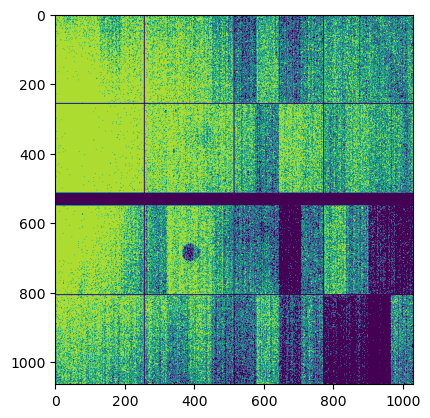

In [45]:
plt.imshow(jg_img.clip(0,1), vmin=0.3, vmax=1.1)

In [22]:
jg_pyfai_az.shape

(23888, 360)

ValueError: x and y must have same first dimension, but have shapes (512,) and (360,)

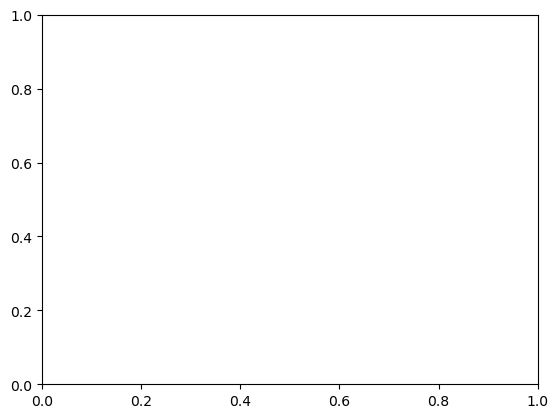

In [21]:
plt.plot(jg_pyfai_q.mean(0), jg_pyfai_az.mean(0))

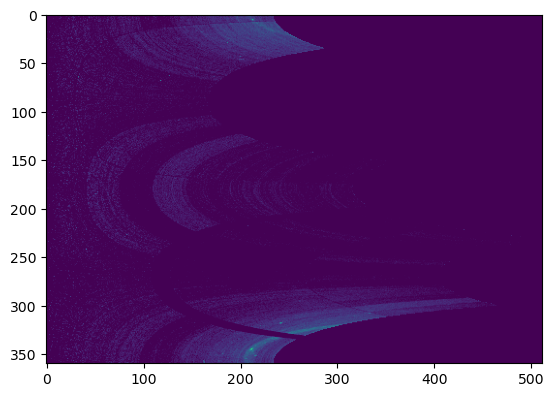

In [132]:
plt.imshow(jg_pyfai_azav.mean(0).clip(0,1))

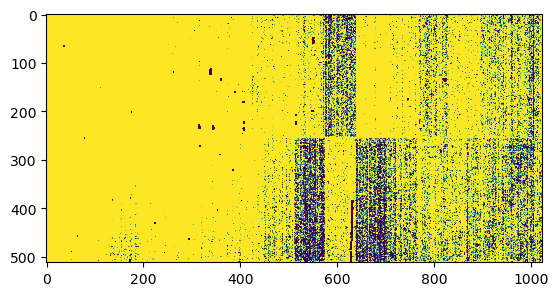

In [28]:
plt.imshow(jg_dropp[0], vmin=10, vmax=1000)

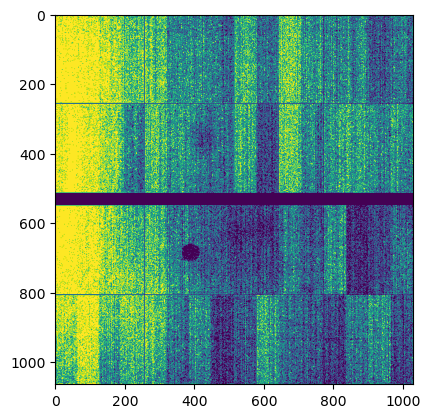

In [40]:
plt.imshow(jg_image.clip(0,1))

In [78]:
np.load(Path(results, 'shared/jf_avg_img_run37.npy'))

array([[ 0.09321147,  0.1155136 ,  0.0887654 , ...,  0.04652562,
        -0.02472121,  0.04491125],
       [ 0.06312935,  0.05344516,  0.0584634 , ...,  0.03616367,
        -0.01050061, -0.00841667],
       [ 0.08691898,  0.06123019,  0.0286689 , ...,  0.05433986,
        -0.02546979, -0.01114561],
       ...,
       [ 0.05798915,  0.06634274,  0.01964636, ...,  0.04988672,
         0.07925056, -0.00143481],
       [ 0.11046901,  0.02560676,  0.09005924, ..., -0.03127465,
         0.03301   , -0.01546209],
       [ 0.09198016,  0.05505609,  0.00756583, ...,  0.00751919,
         0.04080992,  0.0485173 ]])

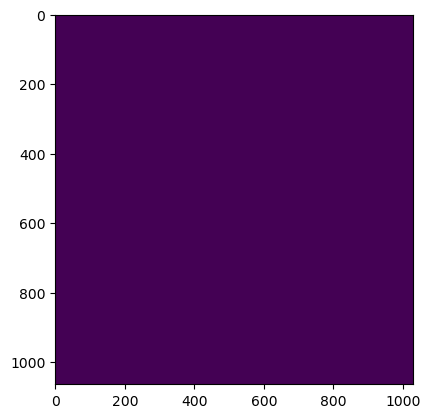

In [77]:
plt.imshow(np.load(Path(results, 'shared/jf_avg_img_run37.npy')), vmin=100, vmax=1000)

## ePix

In [488]:
def assemble_image(imgs):
    """
    return the assembled image of size [2080,2080]
    with the 4 epix
    input: list of 4 epix map
    output: map of size (2080,2080) assembled
    """
    shape = [704,768]
    edge  = [170,140]
    frame = np.zeros([2080,2080])
    #epix1
    frame[  edge[0]:shape[0]+edge[0],  edge[1]:shape[1]+edge[1]] = np.rot90( imgs[0] , 2)
    #epix2
    frame[  edge[0]:shape[0]+edge[0],-edge[1]-shape[1]:-edge[1]] = np.rot90( imgs[1] , 2)
    #epix3
    frame[-edge[0]-shape[0]:-edge[0],  edge[1]:shape[1]+edge[1]] = imgs[2]
    #epix4
    frame[-edge[0]-shape[0]:-edge[0],-edge[1]-shape[1]:-edge[1]] =  imgs[3] 
    return frame

In [489]:
masks=[[],[],[],[]]
N_epix=4

for epix in range(N_epix):
    masks[epix]=np.ones([epix_masks[epix].shape[0], epix_masks[epix].shape[1]])

masks[0][0:354,370:390]=0
masks[0][0:154,680:710]=0

masks[1][350:,635]=0
masks[1][350:,636]=0
masks[1][350:,637]=0
masks[3][507:509,477:479]=0

pixel_out=8
pixel_center1=383
pixel_center2=352
deltapixel=3

for epix in range(N_epix):
    masks[epix][0:pixel_out,:]=0
    masks[epix][:,0:pixel_out]=0
    masks[epix][-pixel_out:,:]=0
    masks[epix][:,-pixel_out:]=0
    
    masks[epix][:,pixel_center1-deltapixel:pixel_center1+deltapixel]=0
    masks[epix][pixel_center2-deltapixel:pixel_center2+deltapixel,:]=0
    epix_masks[epix] = (epix_masks[epix] * masks[epix]).astype(bool)

In [ ]:
# Process each pattern in this run
pixel_num = float(np.sum(total_mask))


epix_imgs = []
p0 = []
p1 = []
p2 = []
p3 = []
imgs_reconstructed = np.zeros([4, 704, 768])
for epix in range(0,4):
    mask = epix_masks[epix]
    shape = mask.shape
    nframe = 1000
    
    # Create arrays for the result
    kbar = np.zeros(nframe)
    _p0 = np.zeros(nframe)
    _p1 = np.zeros(nframe)
    _p2 = np.zeros(nframe)
    _p3 = np.zeros(nframe)
    
    print(f"Processing image of epix: {epix}")
    for frame in tqdm(range(nframe)):
        # sum images
        imgs_reconstructed[epix]+=reconstruct_img(epix_photons_i[epix][frame], epix_photons_j[epix][frame], shape)
        # intensity
        kbar[frame] += np.sum(imgs_reconstructed[epix, total_mask[epix]]) / pixel_num

        # photon probabilities
        p, p_bin_edge = np.histogram(imgs_reconstructed[epix, total_mask[epix]].flatten(), 
                                     bins=[-0.5, 0.5, 1.5, 2.5, 3.5])
        
        _p0[frame] += p[0] / pixel_num
        _p1[frame] += p[1] / pixel_num
        _p2[frame] += p[2] / pixel_num
        _p3[frame] += p[3] / pixel_num
    p0.append(_p0)
    p1.append(_p1)
    p2.append(_p2)
    p3.append(_p3)
    imgs_reconstructed[epix] / nframe
    epix_imgs.append(img)

Processing image of epix: 0


100%|██████████| 1000/1000 [00:33<00:00, 29.93it/s]


Processing image of epix: 1


100%|██████████| 1000/1000 [00:27<00:00, 36.71it/s]


Processing image of epix: 2


100%|██████████| 1000/1000 [00:33<00:00, 29.54it/s]


Processing image of epix: 3


 40%|███▉      | 397/1000 [00:13<00:19, 30.78it/s]

In [ ]:
for i in range(len(imgs_reconstructed)):
    print(f'ePix {i+1}, kbar', np.nanmean(kbar))

In [ ]:
fig, axs = plt.subplots(2,2,tight_layout=True)
for i, ax in enumerate(np.ravel(axs)):
    ax.hist(imgs_reconstructed[i].flatten())
    ax.set_yscale('log')
    ax.set_xlabel('photon_number')
    ax.set_title(f'ePix - {i+1}')

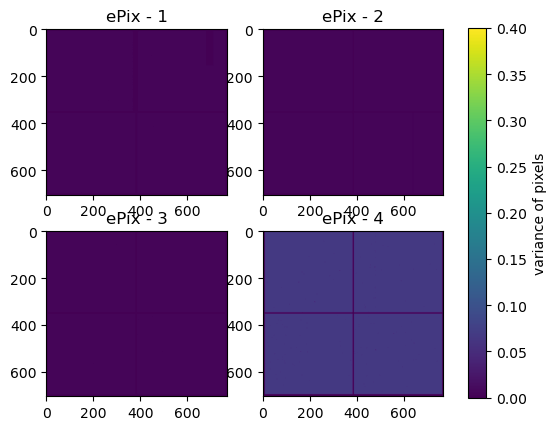

In [623]:
fig, axs = plt.subplots(2,2)
for i, ax in enumerate(np.ravel(axs)):
    im = ax.imshow(epix_masks[i]*np.var(imgs_reconstructed[i]), vmax=0.4)
    ax.set_title(f'ePix - {i+1}')
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), label='variance of pixels')
plt.show()

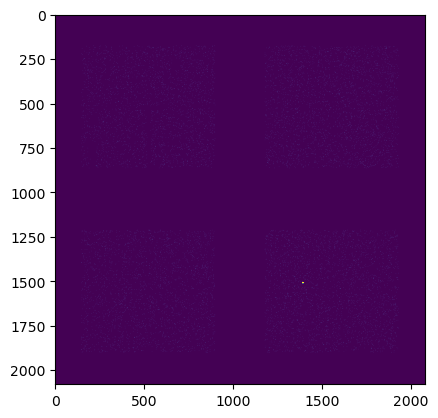

In [583]:
assembled_img = assemble_image(imgs_reconstructed)
assembled_mask = assemble_image(epix_masks).astype(bool)

plt.imshow(assembled_mask*assembled_img, vmin=0, vmax=1)
plt.show()

In [584]:
epix_poni = str(Path(shared, 'poni', '4epix_Lab6_231103.poni'))
ai = pf.load(epix_poni)
q, Iq = ai.integrate1d(assembled_img,
                      500,
                      mask=(~assembled_mask),
                      unit="q_A^-1",
                      filename=f"epixAll_Iq_run{run}.dat")

(500, 2)


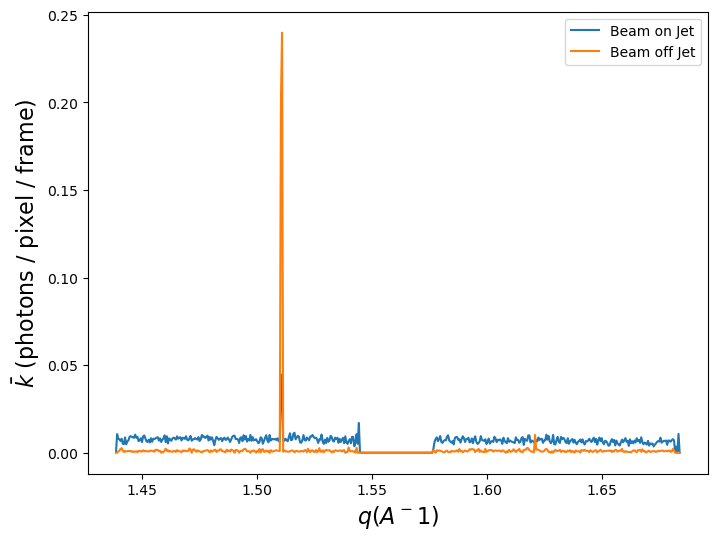

In [585]:
q0=1.53
q1=1.58
Iq_jetoff = np.loadtxt(str(Path(results, "jason", "epixAll_Iq_run69.dat")))
print(Iq_jetoff.shape)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(q, Iq,label="Beam on Jet")
ax.plot(q, Iq_jetoff[:,1],label="Beam off Jet")
ax.legend()
# ax.set_xlim(q0, q1)
ax.set_xlabel('$q (A^-1)$', fontsize=16)
ax.set_ylabel(r'${\bar{k}}$ (photons / pixel / frame)', fontsize=16)
plt.show()

## ePix 5 SAXS

In [142]:
mask = epix5_mask
shape = mask.shape
nframe = len(epix5_photons_i)
nframe = 1000
imgs_reconstruct = np.zeros(np.r_[nframe, shape])
for i in tqdm(range(nframe)):
    imgs_reconstruct[i] = reconstruct_img(epix5_photons_i[i], epix5_photons_j[i], shape)
img = imgs_reconstruct.mean(axis = 0)
np.save(f'{results}/jason/{exp}_{run}_img.npy', img)

100%|██████████| 1000/1000 [00:04<00:00, 227.01it/s]


In [148]:
img.sum()

0.0

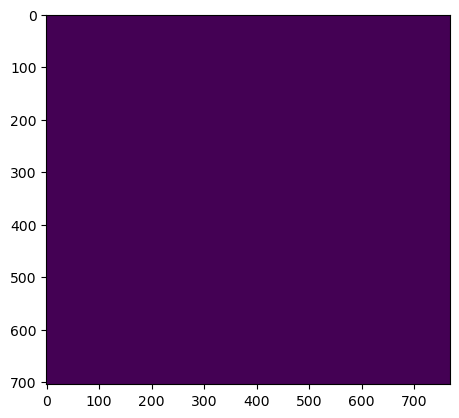

In [146]:
plt.imshow(img, vmin=0, vmax=1e-9)
plt.show()

save average image

In [21]:
mask = np.load(Path(shared, 'mask/xppl1001021_Run0024_epix5_mask.npy'))

In [23]:
nframe = len(epix_photons_i[0])
ps = np.zeros((nframe, 12))
print(ps.shape)
for i in tqdm(range(nframe)):
    ps[i] = np.squeeze(getProb_img(epix_photons_i[0][i], epix_photons_j[0][i], epix_masks[0]))

(17515, 12)


  1%|          | 162/17515 [00:01<03:31, 82.10it/s]


KeyboardInterrupt: 

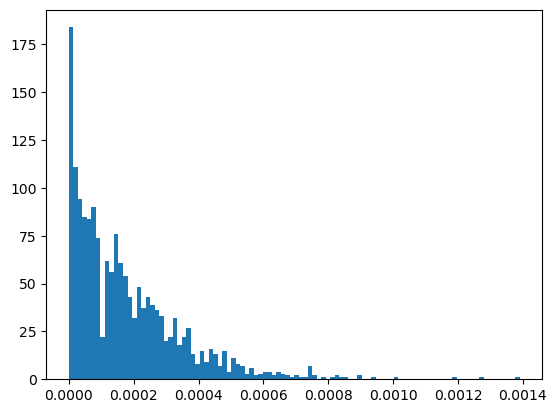

In [29]:
plt.hist(ps[:, -1], bins = 100)

plt.show()

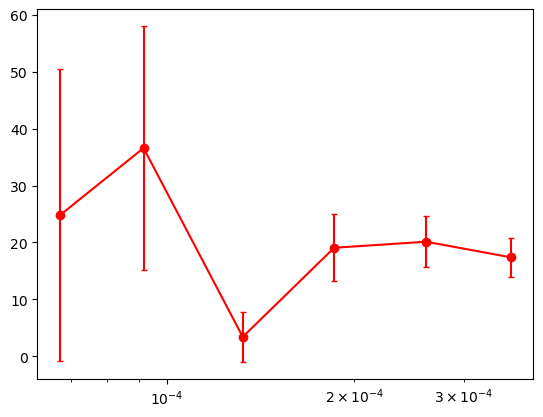

In [31]:
res = intensity_influence_estimator(ps=ps[:,:3], 
                                    kbar=ps[:,-1], 
                                    branch_filter=np.ones((nframe), dtype = 'int'), 
                                    nroi=mask.sum(),
                                    label = '',
                                    binmin =0.000001, 
                                    binmax = 0.0006,
                                    nbin_edge = 20,
                                    color = 'r')
plt.xscale('log')

In [25]:
res[0]

array([0.00115621, 0.00139045,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan])

## Integration

In [59]:
poni_file = str(Path(shared, 'poni', 'xppl1001021_Run0024_epix5_poni.poni'))
# img = np.load(str(Path(results, 'seonju', 'xppl1001021_Run0024_epix5_img.npy')))
ai = pf.load(poni_file)

In [95]:
res = ai.integrate1d(img,
                     1000,
                     mask=mask,
                     unit="q_A^-1",
                     dummy=np.nan)

(0.005, 0.015)

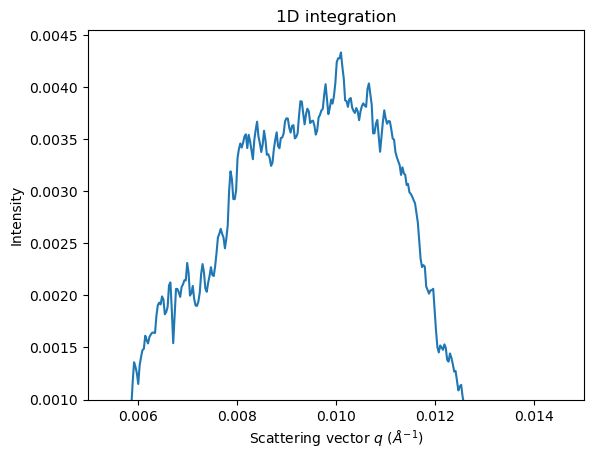

In [100]:
plt_mask = np.where(res[1]>0.001)
ax = jupyter.plot1d(res)
plt.ylim(0.001,)
plt.xlim(0.005, 0.015)